In [1]:
from __future__ import division, print_function, unicode_literals
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.datasets
import scipy.stats as stats

In [2]:
def function_generator(rn, n):
    noise = np.random.normal(0,.1, n)
    function = np.sin(4*np.pi*rn) + noise
    return np.reshape(np.sort(function, axis=0), (n, 1))

In [3]:
n = 50
rn = np.random.uniform(0, 1, n)
x = np.reshape(np.sort(rn, axis=0), (n, 1))
y = function_generator(rn, n)

## 4.1 Performing linear regression with polynomials and radial basis functions

In [4]:
def polynomial_basis_fn(x, degree):
    return x ** degree

def gaussian_basis_fn(x, mu, sigma=0.1):
    return np.exp(-0.5 * (x - x[mu-1]) ** 2 / sigma ** 2)

def make_design(x, basisfn, basisfn_locs=None):
    if basisfn_locs is None:
        return np.concatenate([np.ones(x.shape), basisfn(x)], axis=1)
    else:
        return np.concatenate([np.ones(x.shape)] + [basisfn(x, loc) for loc in basisfn_locs], axis=1)

## 4.2 How does regression generalise? Computing bias and variance

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [6]:
def min_loss_weight(A, reg, y):
    inv = np.linalg.inv(np.matmul(A.T, A) + reg*(np.identity(np.size(A,1))))
    w = np.matmul((np.matmul(inv, A.T)), y)
    return w

### 4.2 Number of basis components

In [7]:
def ar_mse(w, x, y):
    mse_list = []
    w = w.T[0]
    x = x.T[0]
    y = y.T[0]
    for i in range(len(x)):
        error = 0
        for j in range(len(w)):
            error += w[j]*(pow(x[i],j)) 
        mse_list.append((y[i]-error)**2)
    return np.mean(mse_list)

def calcLocs(locNum):
    locs_mse_poly = []
    locs_mse_gauss = []
    
    for i in range(locNum):
        locs_arr = [j for j in range(1,i+1)]

        best_weight_poly = min_loss_weight(make_design(x_train, polynomial_basis_fn, locs_arr), 0.4, y_train)
        mean_sq_poly = ar_mse(best_weight_poly, x_test, y_test)
        locs_mse_poly.append(mean_sq_poly)

        best_weight_gauss = min_loss_weight(make_design(x_train, gaussian_basis_fn, locs_arr), 0.4, y_train)
        mean_sq_gauss = ar_mse(best_weight_gauss, x_test, y_test)
        locs_mse_gauss.append(mean_sq_gauss)
    return [locs_mse_poly, locs_mse_gauss]

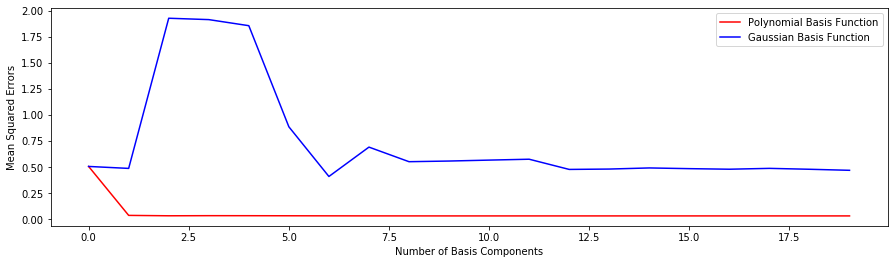

In [8]:
locs_mse_poly, locs_mse_gauss = calcLocs(20)
locs = [i for i in range(20)]
fig, ax = plt.subplots(figsize=(15,4),nrows=1, ncols=1)
ax.plot(locs, locs_mse_poly, c='r', label='Polynomial Basis Function')
ax.plot(locs, locs_mse_gauss, c='b', label='Gaussian Basis Function')
ax.set(xlabel='Number of Basis Components', ylabel='Mean Squared Errors')
ax.legend()

### Strength of the regularisation coefficient

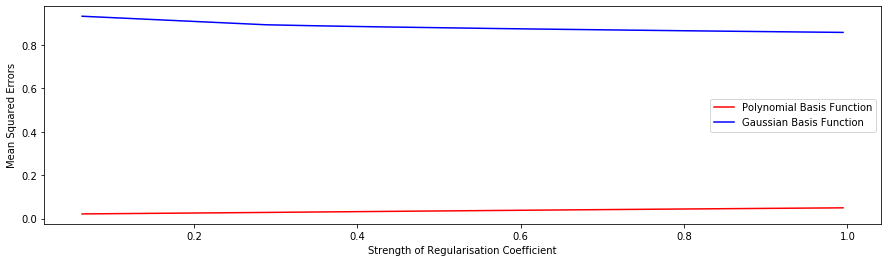

In [9]:
regNum = np.random.uniform(0, 1, 15)
regNum.sort()
regs_poly = []
regs_gauss = []

for i in regNum:
    best_weight_poly = min_loss_weight(make_design(x_train, polynomial_basis_fn, [1,2,3,4,5]), i, y_train)
    mean_sq_poly = ar_mse(best_weight_poly, x_test, y_test)
    regs_poly.append(mean_sq_poly)

    best_weight_gauss = min_loss_weight(make_design(x_train, gaussian_basis_fn, [1,2,3,4,5]), i, y_train)
    mean_sq_gauss = ar_mse(best_weight_gauss, x_test, y_test)
    regs_gauss.append(mean_sq_gauss)

fig, ax1 = plt.subplots(figsize=(15,4),nrows=1, ncols=1)
ax1.plot(regNum, regs_poly, c='r', label='Polynomial Basis Function')
ax1.plot(regNum, regs_gauss, c='b', label='Gaussian Basis Function')
ax1.set(xlabel='Strength of Regularisation Coefficient', ylabel='Mean Squared Errors')
ax1.legend()

## 4.2.2 Bias and Variance

In [10]:
ps = [1,3,6,7,8,10]

def bias(p):

    x_test_design = make_design(x_test, polynomial_basis_fn, [i for i in range(1,p+1)])
    x_poly = []
    x_gauss = []
    m = 100
    
    for i in range(m):
        x_train2, x_test2, y_train2, y_test2 = train_test_split(x_train, y_train)
        best_weight_poly = min_loss_weight(make_design(x_train2, polynomial_basis_fn, [i for i in range(1,p+1)]), 0.4, y_train2)
        x_poly.append(np.matmul(x_test_design, best_weight_poly))
            
        best_weight_gauss = min_loss_weight(make_design(x_train2, gaussian_basis_fn,  [i for i in range(1,p+1)]), 0.4, y_train2)
        x_gauss.append(np.matmul(x_test_design, best_weight_gauss))
    
    x_means_poly = np.zeros(len(x_poly[0]))
    for i in x_poly:
        x_means_poly = np.add(x_means_poly, i)
    x_means_poly = np.matrix([i[0]/m for i in x_means_poly]).T
    bias_poly = np.mean([(i.item(0))**2 for i in np.subtract(y_test, x_means_poly)])
    
    x_means_gauss = np.zeros(len(x_gauss[0]))
    for i in x_gauss:
        x_means_gauss = np.add(x_means_gauss, i)
    x_means_gauss = np.matrix([i[0]/m for i in x_means_gauss]).T
    bias_gauss = np.mean([(i.item(0))**2 for i in np.subtract(y_test, x_means_gauss)])
    
    return [bias_poly, bias_gauss]

for p in ps:
    bias_poly, bias_gauss = bias(p)
    print("For p=" + str(p) +", "+ "Polynomial Bias: " + str(bias_poly) + ", Gaussian Bias: " + str(bias_gauss))

For p=1, Polynomial Bias: 0.04263171434920742, Gaussian Bias: 0.5576848875147657
For p=3, Polynomial Bias: 0.037316637236719616, Gaussian Bias: 0.6107507159983677
For p=6, Polynomial Bias: 0.03592906163598365, Gaussian Bias: 0.48683995629788807
For p=7, Polynomial Bias: 0.03567691397237427, Gaussian Bias: 0.6421648733100701
For p=8, Polynomial Bias: 0.03529692907892259, Gaussian Bias: 0.5356434219040491
For p=10, Polynomial Bias: 0.034856860613687715, Gaussian Bias: 0.5869441047713293


In [11]:
def variance(p):    
    x_test_design = make_design(x_test, polynomial_basis_fn, [i for i in range(1,p+1)])
    x_poly = []
    x_gauss = []
    m = 100
    for i in range(m):
        x_train2, x_test2, y_train2, y_test2 = train_test_split(x_train, y_train)
        best_weight_poly = min_loss_weight(make_design(x_train2, polynomial_basis_fn, [i for i in range(1,p+1)]), 0.4, y_train2)
        x_poly.append(np.matmul(x_test_design, best_weight_poly))
            
        best_weight_gauss = min_loss_weight(make_design(x_train2, gaussian_basis_fn,  [i for i in range(1,p+1)]), 0.4, y_train2)
        x_gauss.append(np.matmul(x_test_design, best_weight_gauss))

    x_vars_poly = np.matrix(np.zeros(len(x_poly[0]))).T
    for i in x_poly:
        mean = np.mean(i)
        var_matrix = []
        for j in i:
            var_matrix.append((j-mean)**2)
        var_matrix = np.matrix(var_matrix)
        x_vars_poly = np.add(x_vars_poly, var_matrix)
    x_vars_poly = ([i[0].item(0)/m for i in x_vars_poly])
    var_poly = np.mean([(i.item(0))**2 for i in np.subtract(y_test, x_vars_poly)])
    
    x_vars_gauss = np.matrix(np.zeros(len(x_gauss[0]))).T
    for i in x_gauss:
        mean = np.mean(i)
        var_matrix = []
        for j in i:
            var_matrix.append((j-mean)**2)
        var_matrix = np.matrix(var_matrix)
        x_vars_gauss = np.add(x_vars_gauss, var_matrix)
    x_vars_gauss = ([i[0].item(0)/m for i in x_vars_gauss])
    var_gauss = np.mean([(i.item(0))**2 for i in np.subtract(y_test, x_vars_gauss)])
    
    return [var_poly, var_gauss]
    
for p in ps:
    var_poly, var_gauss = variance(p)
    print("For p="+str(p)+", "+ "Polynomial Variance: " + str(var_poly) + ", Gaussian Variance: " + str(var_gauss))

For p=1, Polynomial Variance: 1.0367524977285927, Gaussian Variance: 0.5757632919044064
For p=3, Polynomial Variance: 1.5736599625275987, Gaussian Variance: 0.9360936767403416
For p=6, Polynomial Variance: 1.5383733960094714, Gaussian Variance: 1.457090797945038
For p=7, Polynomial Variance: 1.521217420832601, Gaussian Variance: 0.9653580365476417
For p=8, Polynomial Variance: 1.4923709195313017, Gaussian Variance: 0.8270505455536761
For p=10, Polynomial Variance: 1.4886367577706108, Gaussian Variance: 0.9126184519634953


## 5.1 Data 1: separate 2 Gaussians

In [12]:
meanA = [0,0]
covA = [[20,0],[0,100]]
xA = np.random.multivariate_normal(meanA,covA,50)

meanB = [12,2]
covB = [[40,0],[0,40]]
xB = np.random.multivariate_normal(meanB,covB,50)

In [13]:
w1 = np.matrix([4, 2])
w2 = np.matrix([-7, 4])
w3 = np.matrix([3, -7])
w4 = np.matrix([-2, -6])

[Text(0, 0.5, 'y = w.x'),
 Text(0.5, 0, 'data x'),
 Text(0.5, 1.0, 'Histogram for vector [-2,-6]')]

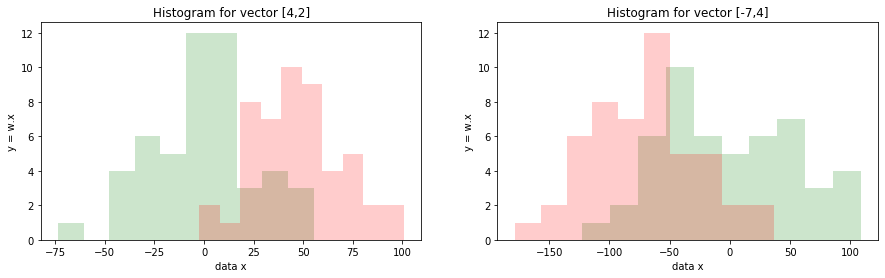

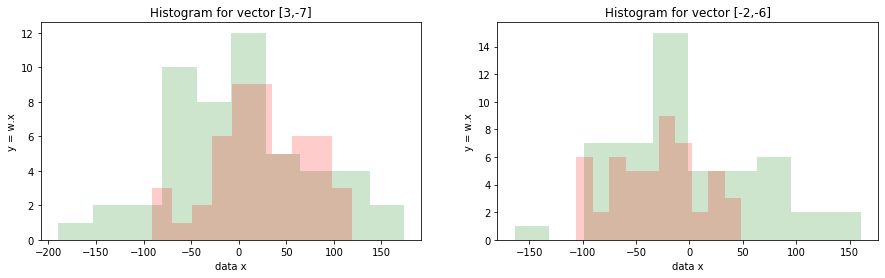

In [14]:
fig, ax2 = plt.subplots(figsize=(15, 4), nrows=1, ncols=2)

yAw1 = []
yAw2 = []
yAw3 = []
yAw4 = []
for i in xA:
    yAw1.append(np.dot(w1,i).item(0))
    yAw2.append(np.dot(w2,i).item(0))
    yAw3.append(np.dot(w3,i).item(0))
    yAw4.append(np.dot(w4,i).item(0))
    
yBw1 = []
yBw2 = []
yBw3 = []
yBw4 = []
for i in xB:
    yBw1.append(np.dot(w1,i).item(0))
    yBw2.append(np.dot(w2,i).item(0))
    yBw3.append(np.dot(w3,i).item(0))
    yBw4.append(np.dot(w4,i).item(0))

ax2[0].hist(yAw1, color='g', alpha=0.2)
ax2[0].hist(yBw1, color='r', alpha=0.2)
ax2[0].set(xlabel='data x', ylabel='y = w.x', title="Histogram for vector [4,2]")
ax2[1].hist(yAw2, color='g', alpha=0.2)
ax2[1].hist(yBw2, color='r', alpha=0.2)
ax2[1].set(xlabel='data x', ylabel='y = w.x', title="Histogram for vector [-7,4]")

fig, ax3 = plt.subplots(figsize=(15, 4), nrows=1, ncols=2)

ax3[0].hist(yAw3, color='g', alpha=0.2)
ax3[0].hist(yBw3, color='r', alpha=0.2)
ax3[0].set(xlabel='data x', ylabel='y = w.x', title="Histogram for vector [3,-7]")
ax3[1].hist(yAw4, color='g', alpha=0.2)
ax3[1].hist(yBw4, color='r', alpha=0.2)
ax3[1].set(xlabel='data x', ylabel='y = w.x', title="Histogram for vector [-2,-6]")

### Dependence of F(w) on the direction of w

In [15]:
def FisherRatio(meanA, varA, nA, meanB, varB, nB):
    num = (meanA-meanB)**2
    denA = nA*varA/(nA+nB)
    denB = nB*varB/(nA+nB)
    return (num/(denA+denB))

def rotate(theta):
    return [[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]]

In [16]:
w0 = np.random.randint(10, size=2)
angles = np.random.uniform(0, 2*np.pi, 500)

In [17]:
def FisherRatios(angles):
    angles.sort()
    
    w_list = []
    for i in angles:
        w_list.append(np.matmul(rotate(i), w0))
    
    fisher_list = []
    for w in w_list:
        
        yAw = []
        for xa in xA:
            yAw.append(np.dot(w, xa))
        
        yBw = []
        for xb in xB:
            yBw.append(np.dot(w, xb))
        
        meanA = np.mean(yAw)
        varA = np.var(yAw)
        lenA = len(yAw)
        
        meanB = np.mean(yBw)
        varB = np.var(yBw)
        lenB = len(yBw)
        
        fisher_list.append(FisherRatio(meanA, varA, lenA, meanB, varB, lenB))
    
    return [fisher_list, w_list]

[Text(0, 0.5, 'Fisher Ratios'),
 Text(0.5, 0, 'Weight Vectors'),
 Text(0.5, 1.0, 'Dependence of Fisher Ratios on Direction of Weight Vectors')]

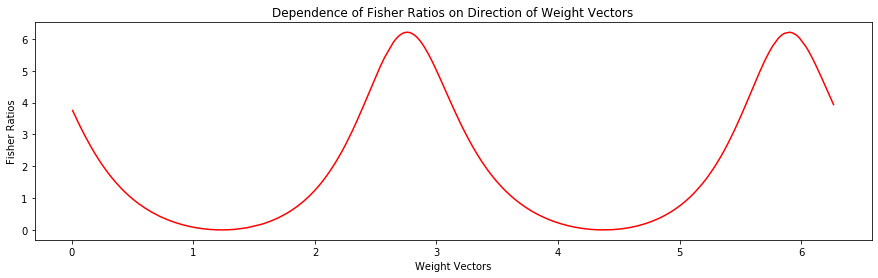

In [18]:
fisher_list, weight_list = FisherRatios(angles)

fig, ax = plt.subplots(figsize=(15, 4), nrows=1, ncols=1)
ax.plot(angles, fisher_list, c='r')
ax.set(xlabel='Weight Vectors', ylabel='Fisher Ratios', title="Dependence of Fisher Ratios on Direction of Weight Vectors")

In [19]:
fisher_max = np.max(fisher_list)
w_star = weight_list[np.argmax(fisher_list)]

print("Maximum value of F(w(\u03B8)): " + str(fisher_max))
print("w* = argmax(F(w(\u03B8))) = " + str(w_star))

Maximum value of F(w(θ)): 6.213348991916437
w* = argmax(F(w(θ))) = [-8.91402308 -0.73497786]


### Probability Distribution Visualisation

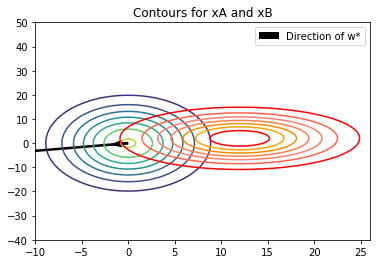

In [20]:
disA = stats.multivariate_normal(meanA, covA)
X_pts = np.linspace(-10, 20, 100)
Y_pts = np.linspace(-40, 50, 100)
X, Y = np.meshgrid(X_pts, Y_pts)
Z = disA.pdf(np.dstack([X, Y]))
plt.title("Contours for xA and xB")
plt.contour(X, Y, Z)
plt.quiver(w_star[0], w_star[1])

disB = stats.multivariate_normal(meanB, covB)
X_pts = np.linspace(-5, 26, 100)
Y_pts = np.linspace(-25, 30, 100)
X, Y = np.meshgrid(X_pts, Y_pts)
Z = disB.pdf(np.dstack([X, Y]))
plt.contour(X, Y, Z, colors=[ 'r', 'red', 'tomato', 'salmon', 'coral', 'darkorange', 'orange'])
plt.quiver(w_star[0], w_star[1], scale=4.5, scale_units="inches", label= "Direction of w*")
plt.legend()

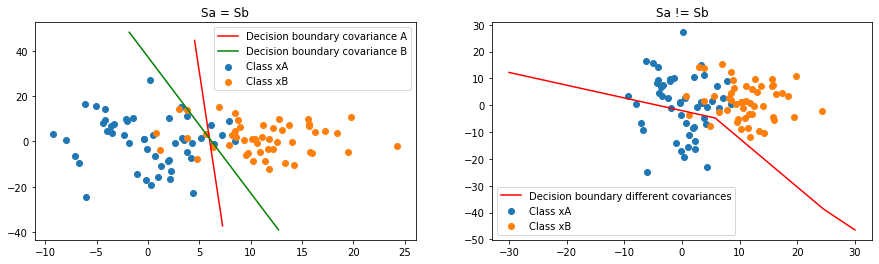

In [21]:
def log_odds(cov1, cov2, mean1, mean2, pts, ty):
    mean1 = np.matrix(mean1).T
    mean2 = np.matrix(mean2).T
    
    cov_inv1 = np.linalg.inv(cov1)
    cov_term1 = 0.5*np.log(np.linalg.det(cov_inv1))
    
    cov_inv2 = np.linalg.inv(cov2)
    cov_term2 = 0.5*np.log(np.linalg.det(cov_inv2))

    log_odds_pts = []
    
    for x in pts:
        x = np.matrix(np.array(x)).T
        
        rterm_minus = np.matmul(np.matmul((x-mean1).T,cov_inv1),(x-mean1))
        g_minus = cov_term1 - 0.5*rterm_minus
        
        rterm_plus = np.matmul(np.matmul((x-mean2).T,cov_inv2),(x-mean2))
        g_plus = cov_term2 - 0.5*rterm_plus
        
        g = g_plus.item(0)-g_minus.item(0)

        if (ty=="A"):
            if (g>=0 and g<0.01):
                log_odds_pts.append(np.array(x.T)[0])
            elif (g>-0.01 and g<0):
                log_odds_pts.append(np.array(x.T)[0])
        elif (ty=="B"):
            if (g>=0 and g<0.025):
                log_odds_pts.append(np.array(x.T)[0])
            elif (g>-0.025 and g<0):
                log_odds_pts.append(np.array(x.T)[0])
        elif (ty=="N"):
            if (g>=0 and g<0.005):
                log_odds_pts.append(np.array(x.T)[0])
            elif (g>-0.005 and g<=0):
                log_odds_pts.append(np.array(x.T)[0])
    
    return log_odds_pts

x_pts = list(np.linspace(-10, 35, 100))
y_pts = list(np.linspace(-40, 50, 100))
pts = [(x,y) for x in x_pts for y in y_pts]

log_odds_eqA = log_odds(covA, covA, meanA, meanB, pts, "A")
log_odds_eqB = log_odds(covB, covB, meanA, meanB, pts, "B")

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
sct_xA = [i[0] for i in xA]
sct_yA = [i[1] for i in xA]

sct_xB = [i[0] for i in xB]
sct_yB = [i[1] for i in xB]

ax[0].scatter(sct_xA, sct_yA, label="Class xA")
ax[0].scatter(sct_xB, sct_yB, label="Class xB")

odds0A_x = [i[0] for i in log_odds_eqA]
odds0A_y = [i[1] for i in log_odds_eqA]
ax[0].plot(odds0A_x, odds0A_y, c='r', label="Decision boundary covariance A")

odds0B_x = [i[0] for i in log_odds_eqB]
odds0B_y = [i[1] for i in log_odds_eqB]
ax[0].plot(odds0B_x, odds0B_y, c='g', label="Decision boundary covariance B")
ax[0].set_title("Sa = Sb")
ax[0].legend()

x_pts = list(np.linspace(-30, 30, 100))
y_pts = list(np.linspace(-50, 20, 100))
pts = [(x,y) for x in x_pts for y in y_pts]

ax[1].scatter(sct_xA, sct_yA, label="Class xA")
ax[1].scatter(sct_xB, sct_yB, label="Class xB")

log_odds_neq = log_odds(covA, covB, meanA, meanB, pts, "N")
odds0_x = [i[0] for i in log_odds_neq]
odds0_y = [i[1] for i in log_odds_neq]
ax[1].plot(odds0_x, odds0_y, c='r', label="Decision boundary different covariances")
ax[1].set_title("Sa != Sb")
ax[1].legend()

## 5.2 Data 2: Iris data 

In [22]:
iris_data = sklearn.datasets.load_iris()
x_iris = iris_data.data
y_iris = iris_data.target

In [23]:
means = []
for i in range(0,3):
    means.append(np.mean(x_iris[y_iris==i], axis=0))

means = [np.matrix(i).T for i in means]

In [24]:
def cal_sigmaB(mean):
    sigmaB = 0
    for muc in means:
        sigmaB += (np.matmul((muc - mean),(muc - mean).T))
    sigmaB = sigmaB/3
    return sigmaB

sigmaB = cal_sigmaB(np.mean(means,axis=0))

In [25]:
# I performed the computation below with some help from this link: https://sebastianraschka.com/Articles/2014_python_lda.html#lda-in-5-steps
sigmaW = np.zeros((4,4))
for i, j in zip(range(0,3), means):
    cov_matrix = np.zeros((4,4))
    for row in x_iris[y_iris == i]:
        row, m = row.reshape(4,1), j.reshape(4,1)
        cov_matrix += (row-j).dot((row-j).T)
    sigmaW += cov_matrix
sigmaW = np.matrix(sigmaW)

In [26]:
eig_val, eig_vector = np.linalg.eigh(np.matmul(np.linalg.inv(sigmaW), sigmaB))
max_index = list(eig_val).index(np.max(eig_val))
w_optimal = np.matrix(eig_vector[:, max_index])

In [27]:
class1 = [np.array(i) for i in x_iris[y_iris==0]]
class2 = [np.array(i) for i in x_iris[y_iris==1]]
class3 = [np.array(i) for i in x_iris[y_iris==2]]

plot_class1 = []
for i in class1:
    i = np.matrix(i)
    plot_class1.append(np.dot(i, w_optimal).item(0))

plot_class2 = []
for i in class2:
    i = np.matrix(i)
    plot_class2.append(np.dot(i, w_optimal).item(0))
    
plot_class3 = []
for i in class3:
    i = np.matrix(i)
    plot_class3.append(np.dot(i, w_optimal).item(0))

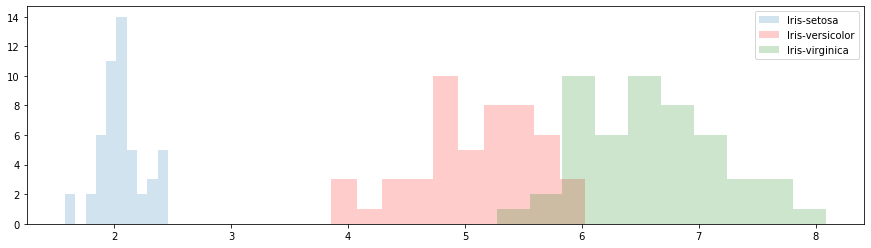

In [28]:
fig, ax = plt.subplots(figsize=(15, 4), nrows=1, ncols=1)
ax.hist(plot_class1, alpha=0.2, label="Iris-setosa")
ax.hist(plot_class2, color='r', alpha=0.2, label="Iris-versicolor")
ax.hist(plot_class3, color='g', alpha=0.2, label="Iris-virginica")
ax.legend()